<a href="https://colab.research.google.com/github/abdelh17/COMP432-GroupG/blob/main/432_project_GroupG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# the 3 datasets can be found in the zip file in this drive document
!gdown 1wK7-PccXDY7tGTzQpwLD7Ok1krBxcvhi

Downloading...
From: https://drive.google.com/uc?id=1wK7-PccXDY7tGTzQpwLD7Ok1krBxcvhi
To: /content/project_datasets.zip
100% 1.23G/1.23G [00:20<00:00, 60.9MB/s]


In [ ]:
zip_file_path = 'project_datasets.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

# names of the datasets
extracted_dirs = ['d1_colorectal_cancer', 'd2_prostate_cancer', 'd3_animal_faces']
# dictionary of datasets
datasets_dict = {}


In [ ]:
# resize, make tensor, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)), #for resnet18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# applies transformations and adds subfolder in the dictionary
for dir_name in extracted_dirs:
    dataset_path = os.path.join('project_datasets/', dir_name)
    if os.path.exists(dataset_path):
        datasets_dict[dir_name] = datasets.ImageFolder(dataset_path, transform=transform)
    else:
        print(f"The directory {dataset_path} does not exist.")

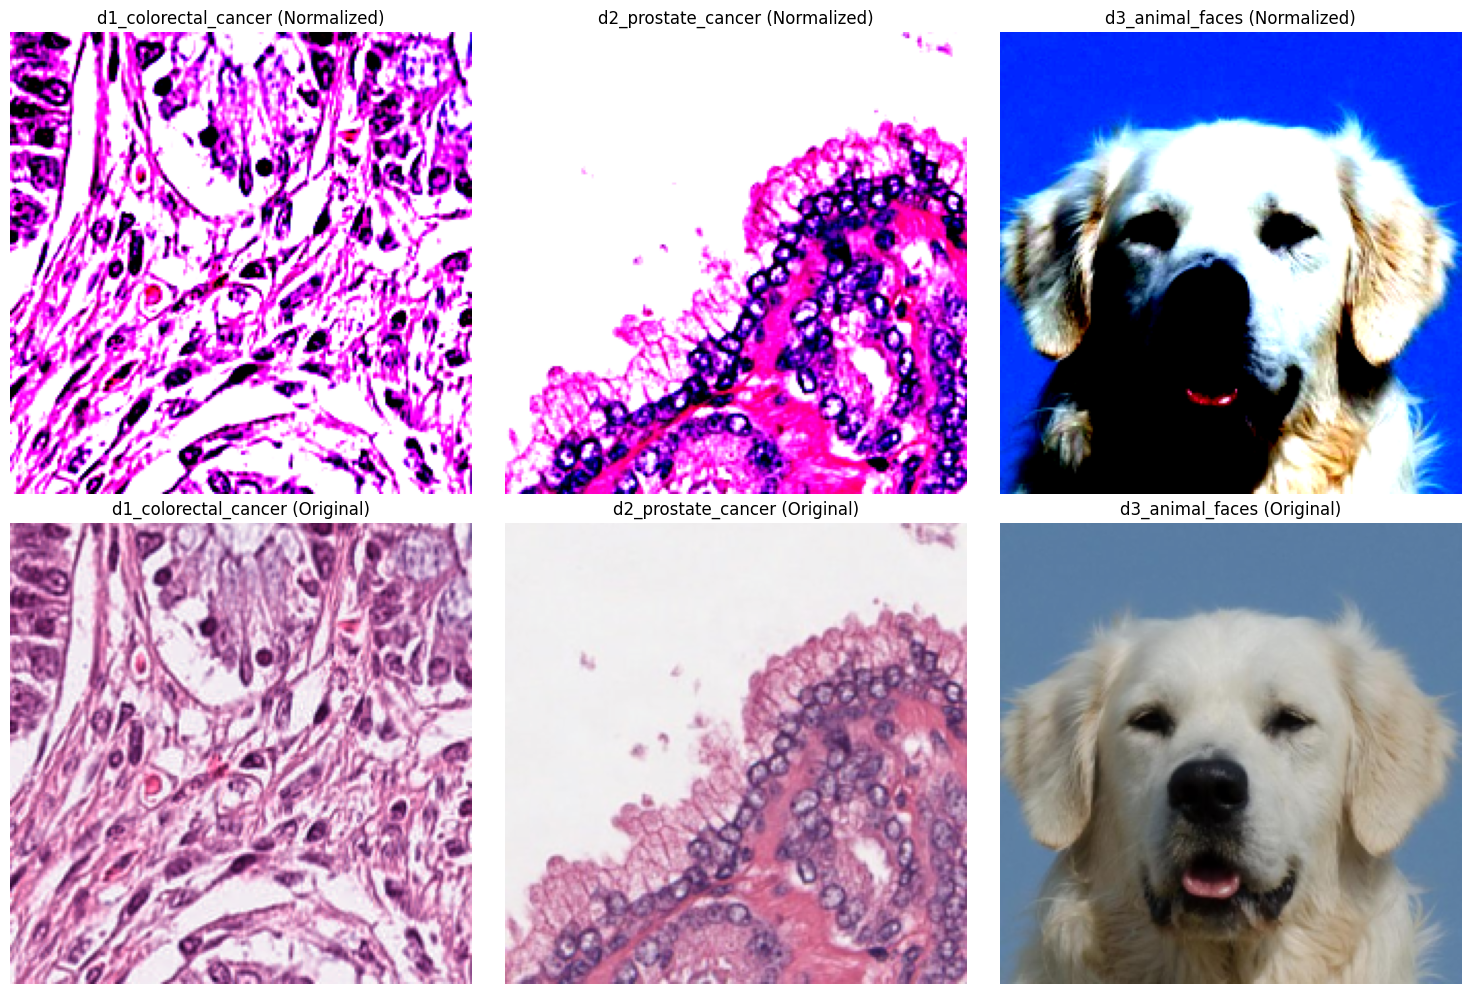

In [ ]:
# need to unnormalize to show the original image since it was normalized in the previous step
def unnormalize(img_tensor):
    img = img_tensor.clone()  # Clone the tensor to avoid modifying it
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor image

    # unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean  # Apply the reverse of normalization
    img = np.clip(img, 0, 1)

    return img

# plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

dataset_names = list(datasets_dict.keys())

for j in range(3):
    dataset_name = dataset_names[j]
    dataset = datasets_dict[dataset_name]

    # randomly choose image in dataset
    img_tensor, _ = random.choice(dataset)

    # display normalized image
    axs[0, j].imshow(img_tensor.permute(1, 2, 0))
    axs[0, j].set_title(f"{dataset_name} (Normalized)")
    axs[0, j].axis('off')

    # display original image
    unorm_img = unnormalize(img_tensor)

    axs[1, j].imshow(unorm_img)
    axs[1, j].set_title(f"{dataset_name} (Original)")
    axs[1, j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
batch_size = 32

dataset_colorectal = datasets_dict['d1_colorectal_cancer']

train_size = int(0.7 * len(dataset_colorectal))
test_size = len(dataset_colorectal) - train_size

train_dataset, test_dataset = random_split(dataset_colorectal, [train_size, test_size])

colorectal_loader = DataLoader(dataset_colorectal, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# use untrained ResNet model
model = resnet18(weights=None)

# outputs of the layer before the fc layer (512)
num_ftrs = model.fc.in_features

# remove fully connected layer for feature extraction
model.fc = nn.Identity()

# add fc for predictions
num_classes = 3
model.fc_pred = nn.Linear(in_features=num_ftrs, out_features=num_classes)

model.to(device)

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.7)

# learning rate is modified by a factor of 0.1 each 5 epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 10

# for plotting accuracy and loss
epoch_accuracies=[]
epoch_losses=[]

# training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    # calculate 1 epoch time
    if epoch == 0:
      start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() #zero the previous gradients

        outputs = model(inputs)
        predictions = model.fc_pred(outputs)
        loss = criterion(predictions, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(predictions, 1)
        running_corrects += torch.sum(preds == labels.data)

    if epoch == 0:
      end_time = time.time()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_corrects.double() / len(train_loader.dataset)

    epoch_accuracies.append(epoch_accuracy.item())
    epoch_losses.append(epoch_loss)

    scheduler.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%')
print(f"Wall clock time for one epoch: {end_time-start_time}")

Epoch 1/10, Train Loss: 0.5597, Train Accuracy: 75.83%
Epoch 2/10, Train Loss: 0.3274, Train Accuracy: 87.76%
Epoch 3/10, Train Loss: 0.2627, Train Accuracy: 90.17%
Epoch 4/10, Train Loss: 0.2036, Train Accuracy: 92.62%
Epoch 5/10, Train Loss: 0.1931, Train Accuracy: 93.10%
Epoch 6/10, Train Loss: 0.0991, Train Accuracy: 96.33%
Epoch 7/10, Train Loss: 0.0865, Train Accuracy: 96.83%
Epoch 8/10, Train Loss: 0.0815, Train Accuracy: 97.10%
Epoch 9/10, Train Loss: 0.0728, Train Accuracy: 97.36%
Epoch 10/10, Train Loss: 0.0655, Train Accuracy: 97.76%
Wall clock time for one epoch: 25.646374940872192


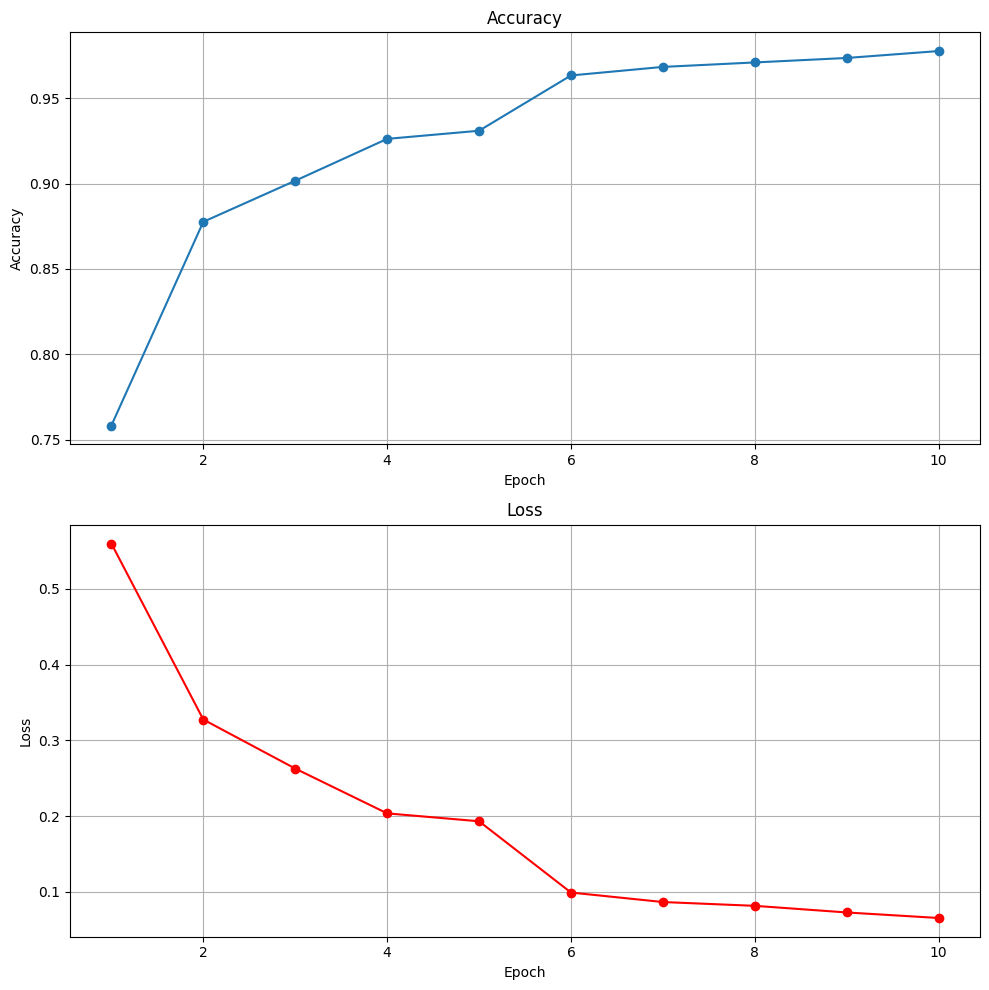

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', color='r')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Adjust layout to prevent clipping of ylabel
plt.tight_layout()

plt.show()


In [ ]:
# testing loop
model.eval() #won't compute gradients
test_loss = 0.0
total = 0
correct = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        predictions = model.fc_pred(outputs)
        loss = criterion(predictions, labels)
        test_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # needed for recall and precision
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

test_accuracy = correct / total
print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')


Test Loss: 0.0740, Test Accuracy: 97.83%


In [ ]:
# calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Precision: 0.9787, Recall: 0.9783, F1-Score: 0.9783


In [ ]:
def extract_features(model, data_loader):
    model.eval()

    all_features = []
    all_true_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # extract features
            outputs = model(inputs)

            all_features.extend(outputs.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # convert features to a np array
    all_features_array = np.array(all_features)
    all_labels_array = np.array(all_true_labels)

    return all_features_array, all_labels_array


In [ ]:
def visualize_tsne(features, labels, title):
  # apply tSNE for dimensionality reduction
    features_tsne = TSNE(n_components=2, random_state=42).fit_transform(features)

    # plot
    plt.figure(figsize=(10, 8))
    plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar()
    plt.title(f"{title}")
    plt.axis("off")
    plt.show()

In [ ]:
colorectal_features, colorectal_labels = extract_features(model, colorectal_loader)

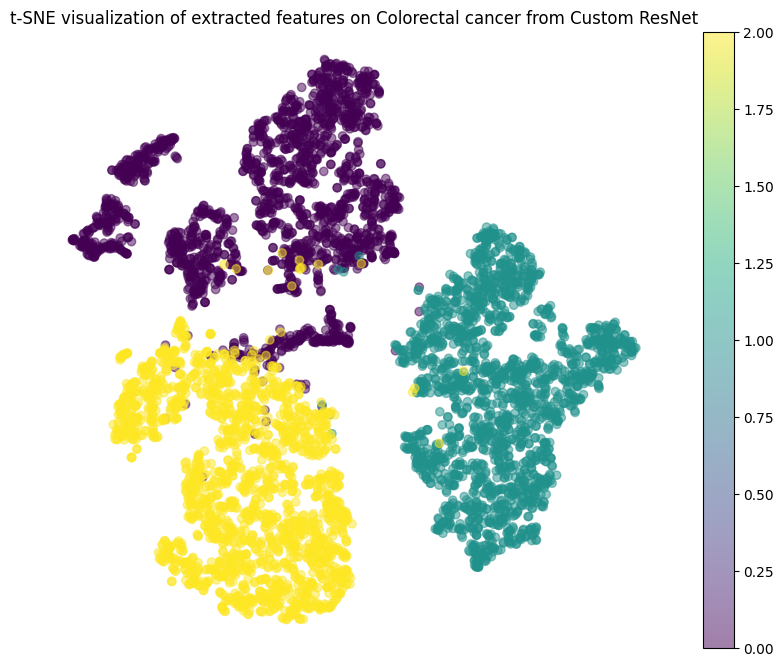

In [ ]:
visualize_tsne(colorectal_features, colorectal_labels, title="t-SNE visualization of extracted features on Colorectal cancer from Custom ResNet")

**Class 0 - PURPLE - MUS  
Class 1 - BLUE-GREEN - NORM  
Class 2 - YELLOW - STR**

In [ ]:
batch_size = 32

dataset_prostate = datasets_dict['d2_prostate_cancer']

dataloader_prostate = DataLoader(dataset_prostate,batch_size=batch_size, shuffle=False)

In [ ]:
prostate_features, prostate_labels = extract_features(model, dataloader_prostate)
visualize_tsne(prostate_features, prostate_labels,  title = "t-SNE visualization of extracted features on prostate cancer from Custom ResNet")

Class 0 - PURPLE - GLAND
Class 1 - BLUE-GREEN - NONGLAND
Class 2 - YELLOW - TUMOR

In [ ]:
animals_features, animals_labels = extract_features(model, dataloader_animals)
visualize_tsne(animals_features, animals_labels, "t-SNE visualization of extracted features on animal faces from Custom ResNet")

**Class 0 - PURPLE - CAT  
Class 1 - BLUE-GREEN - DOG  
Class 2 - YELLOW - WILD**